In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.applications import vgg16, vgg19

In [2]:

# Get base project directory
project_path = Path(os.getcwd()).parent.parent
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        # image=image/255.0
        data.append(image)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

def get_training_set(CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"3_aug_{v}_train/").rglob("*"))
        # print(folder_paths)
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

# Dataset inspect
# Read images to variables
size = 224
# X_train, y_train = get_training_set(CLASSES, size)
X_train, y_train = get_sets('train', CLASSES, size)
X_val, y_val = get_sets('val', CLASSES, size)
X_test, y_test = get_sets('test', CLASSES, size)

In [3]:
np.asarray(X_train).shape

(125, 224, 224, 3)

In [41]:
base_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(X_train[0].shape[0], X_train[0].shape[1], 3))
base_model.trainable = False

In [42]:
from keras import Model
import keras
from keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
import tensorflow as tf
from keras.callbacks import ModelCheckpoint


inputs = Input(shape=(X_train[0].shape[0], X_train[0].shape[1], 3))
x = vgg16.preprocess_input(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_9   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_9 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [43]:
checkpoint_filepath = (Path(os.getcwd()) /'model_checkpoint/model_checkpoint')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [44]:
metrics = ['accuracy']

opt = tf.keras.optimizers.Adam()#learning_rate=0.0006)
# opt = tf.keras.optimizers.ad(learning_rate=0.00015)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)
# model.compile(loss="binary_crossentropy", optimizer='adam', metrics=metrics)

callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val),np.array(y_val)), epochs=50, batch_size=30, verbose=2, callbacks=[callbacks, model_checkpoint_callback])

Epoch 1/50
5/5 - 4s - loss: 1.5670 - accuracy: 0.5840 - val_loss: 1.2986 - val_accuracy: 0.4524 - 4s/epoch - 708ms/step
Epoch 2/50
5/5 - 1s - loss: 1.2807 - accuracy: 0.5040 - val_loss: 1.2536 - val_accuracy: 0.4524 - 841ms/epoch - 168ms/step
Epoch 3/50
5/5 - 2s - loss: 1.2276 - accuracy: 0.5440 - val_loss: 1.1208 - val_accuracy: 0.5000 - 2s/epoch - 460ms/step
Epoch 4/50
5/5 - 2s - loss: 1.0545 - accuracy: 0.5680 - val_loss: 1.1013 - val_accuracy: 0.5714 - 2s/epoch - 463ms/step
Epoch 5/50
5/5 - 1s - loss: 0.9814 - accuracy: 0.6080 - val_loss: 1.0103 - val_accuracy: 0.5714 - 875ms/epoch - 175ms/step
Epoch 6/50
5/5 - 1s - loss: 0.9005 - accuracy: 0.6240 - val_loss: 0.9054 - val_accuracy: 0.5476 - 833ms/epoch - 167ms/step
Epoch 7/50
5/5 - 1s - loss: 0.8474 - accuracy: 0.6640 - val_loss: 0.8489 - val_accuracy: 0.5714 - 839ms/epoch - 168ms/step
Epoch 8/50
5/5 - 1s - loss: 0.7961 - accuracy: 0.6640 - val_loss: 0.7924 - val_accuracy: 0.5714 - 837ms/epoch - 167ms/step
Epoch 9/50
5/5 - 2s - los

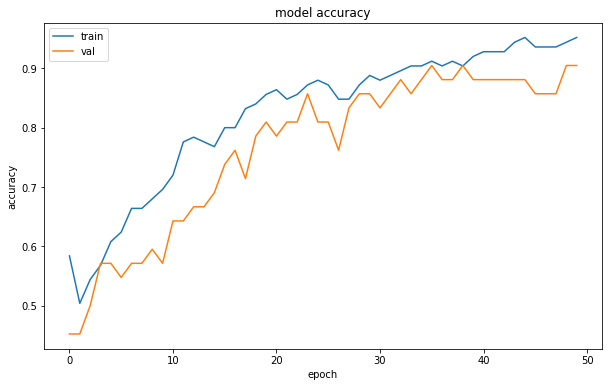

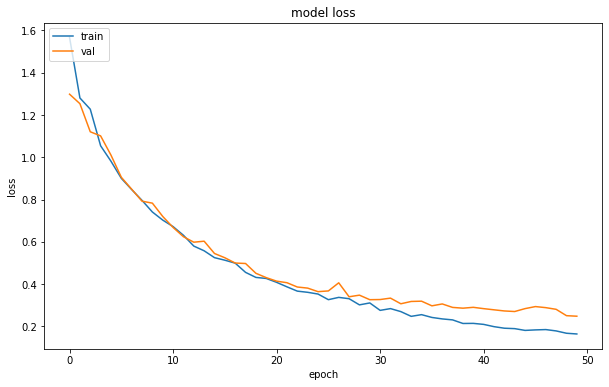

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
CLASS_NAMES = ['yes', 'no']


plt.figure(figsize = (10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize = (10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

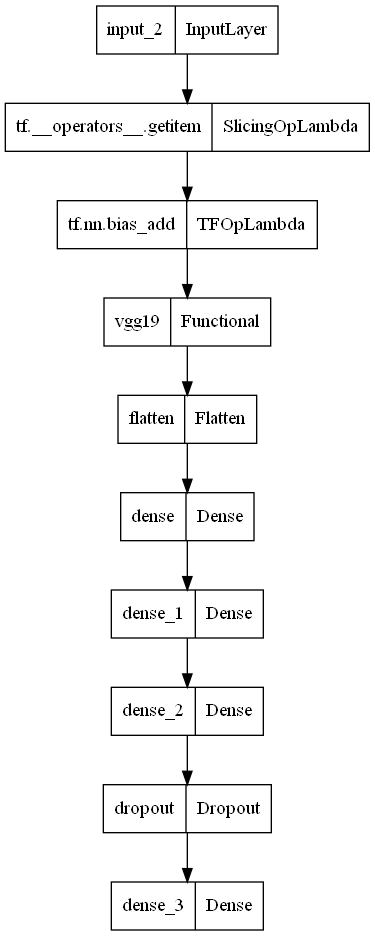

In [7]:
tf.keras.utils.plot_model(model)